# Court Vision Pipeline
### Single Stationary Camera
1. Detect lines or corners of court in a single frame of the clip
2. Compute the homography between the image and the base world frame
3. Make image plane detections. People, Ball etc.
4. Project detections onto base world frame

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from torchvision.io import read_image
from courtvision.geometry import (
    get_corners_image,
    get_coords_world_3d_n,
    corners_world_n,
    convert_corners_to_vec,
    PadelCourt,
    compute_homography,
    project_points_to_base_plane
)
from courtvision.geometry import corners_world_3d
import numpy as np
from courtvision.vis import plot_n_images_in_a_grid, load_timg, plot_3d_lines, plot_3d_points
from courtvision.swiss import save_camera_params
import cv2
import torch
import matplotlib.pyplot as plt

import rerun as rr





In [2]:
annotated_frame = Path(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/curated_001_frame_0001.png"
)
src_corners_n = get_corners_image(annotated_frame)
dst_corners_n = corners_world_n.copy()

named_points_not_labelled_in_image = set(dst_corners_n.keys()) - set(
    src_corners_n.keys()
)
for key in named_points_not_labelled_in_image:
    print(f"Removing {key=}")
    dst_corners_n.pop(key)

Removing key='j_net_line_left'
Removing key='i_center_line_far'
Removing key='k_center_line_near'
Removing key='l_net_line_right'


In [3]:
src_corners_n, dst_corners_n

({'a_front_left': (0.1111111111111111, 0.8790123456790124),
  'b_front_right': (0.8944444444444444, 0.8864197530864197),
  'c_back_left': (0.3138888888888889, 0.291358024691358),
  'd_back_right': (0.6916666666666668, 0.2938271604938272),
  'e_left_near_serve_line': (0.16612377850162863, 0.7258687258687259),
  'f_right_near_serve_line': (0.8414766558089035, 0.7277992277992279),
  'g_left_far_serve_line': (0.29641693811074915, 0.3436293436293436),
  'h_right_far_serve_line': (0.7096774193548387, 0.3438735177865613)},
 {'a_front_left': (0.0, 0.0),
  'b_front_right': (1.0, 0.0),
  'c_back_left': (0.0, 1.0),
  'd_back_right': (1.0, 1.0),
  'e_left_near_serve_line': (0.0, 0.1),
  'f_right_near_serve_line': (1.0, 0.1),
  'g_left_far_serve_line': (0.0, 0.9),
  'h_right_far_serve_line': (1.0, 0.9)})

In [4]:
H, _, _ = compute_homography(
    annotated_frame=annotated_frame,
    src_corners_n=src_corners_n,
    dst_corners_n=dst_corners_n,
)
save_camera_params(
    file_name=annotated_frame,
    homography=H,
)

In [5]:
H

array([[ 4.13237653e+00,  2.44007051e+00, -2.16170501e+03],
       [-4.40189239e-02,  2.00111158e+01, -4.30414418e+03],
       [-5.98347134e-06,  4.87951036e-03,  1.00000000e+00]])

In [6]:
# frames = sorted(annotated_frame.parent.glob("*.png"))
frames = sorted(
    Path("/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001").glob(
        "*.png"
    )
)
len(frames)

420

In [7]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

# model.classes = [0]
# model.conf = 0.6
# model.max_det = 4
# results = model.track(
#     source="/Users/benjamindecharmoy/projects/courtvision/data/raw/curated_001.mp4",
#     # tracker="/Users/benjamindecharmoy/projects/courtvision/bytetrack.yaml",
#     tracker="/Users/benjamindecharmoy/projects/courtvision/botsort.yml",
#     classes=[0],
#     max_det=4,
#     save=True,
# )

from pickle import load, dump

# dump(results, open("results.pkl", "wb"))
results = load(open("results.pkl", "rb"))

In [8]:
from courtvision.models import get_fasterrcnn_ball_detection_model
from courtvision.swiss import get_latest_file

ball_detector_model_path = get_latest_file(
    Path("/Users/benjamindecharmoy/projects/courtvision/models/ball_detector/")
)
model_name = ball_detector_model_path.stem
ball_detector = get_fasterrcnn_ball_detection_model(ball_detector_model_path).eval()

In [9]:
from collections import defaultdict
from kornia import image_to_tensor

base_results = defaultdict(list)
from datetime import datetime

rr.init(
    f"Curated_001-{datetime.now()}", spawn=True
)  # Spawn a Rerun Viewer and stream log events to it

colours_per_idx = defaultdict(lambda: (255, 255, 255))
colours_per_idx.update(
    {
        0: (0, 255, 0),
        1: (0, 0, 255),
        2: (255, 0, 0),
        3: (255, 255, 0),
        4: (255, 0, 255),
        5: (0, 255, 255),
    }
)
court_layout = cv2.imread(
    "/Users/benjamindecharmoy/projects/courtvision/notebooks/test.png"
)
court_layout = cv2.resize(court_layout, (int(PadelCourt.width), int(PadelCourt.length)))

front_wall_layout = cv2.imread(
    "/Users/benjamindecharmoy/projects/courtvision/notebooks/frontwall.png"
)
front_wall_layout = cv2.resize(
    front_wall_layout, (int(PadelCourt.width), int(PadelCourt.backwall_height))
)
rr.log_image("court_layout", court_layout)
for i, (frame, result) in enumerate(zip(frames, results)):
    rr.set_time_sequence("play", i)
    rr.log_image("court_layout", court_layout)
    rr.log_image("court_frontwall", front_wall_layout)
    with torch.no_grad():

        outputs = ball_detector(
            image_to_tensor(result.orig_img, keepdim=False).float() / 255.0,
            # read_image(frame.as_posix()).unsqueeze(0).float() / 255.0,
        )
    if outputs and len(outputs[0]["boxes"]) > 0:
        for bx1, by1, bx2, by2 in outputs[0]["boxes"][:4]:
            # bx1, by1, bx2, by2 = outputs[0]["boxes"][0]
            rr.log_rect(
                f"rgb_image/Ball",
                (bx1, by1, bx2 - bx1, by2 - by1),
                color=colours_per_idx[-1],
            )
        H_to_vertical_plane = np.array(
            [
                [9.09142405e-01, -9.66439760e-02, -6.81353581e01],
                [5.93720192e-04, 9.54040584e-01, -3.36254241e02],
                [1.98251071e-05, -1.74933071e-04, 1.00000000e00],
            ]
        )
        court_plane_vertical = cv2.warpPerspective(
            result.orig_img,
            H_to_vertical_plane,
            dsize=(int(PadelCourt.width), int(PadelCourt.backwall_height)),
        )
        ball_on_image_plane = torch.tensor([((bx1 + bx2) / 2, (by1 + by2) / 2)])
        (ball_on_vertical_plane,) = project_points_to_base_plane(
            points=ball_on_image_plane, H=H_to_vertical_plane
        )
        # ball_on_vertical_plane = (ball_on_vertical_plane[0], PadelCourt.backwall_height-ball_on_vertical_plane[1])
        rr.log_point(
            "court_frontwall/Ball",
            ball_on_vertical_plane,
            radius=5,
            color=colours_per_idx[-1],
        )
        rr.log_image("court_frontwall/glass", court_plane_vertical)
    rr.log_image("rgb_image", result.orig_img)

    court_plane = cv2.warpPerspective(
        result.orig_img,
        H,
        dsize=(int(PadelCourt.width), int(PadelCourt.length)),
    )
    rr.log_image("court_plane", court_plane)

    # rr.log_points("points", positions)
    for det in result.boxes.data:
        x1, y1, x2, y2, idx, conf, cls = det
        rr.log_rect(
            f"rgb_image/Player_{int(idx)}",
            (x1, y1, (x2 - x1), (y2 - y1)),
            color=colours_per_idx[int(idx)],
        )
        mid_feet = torch.tensor([((x1 + x2) / 2, (y2 + y2) / 2)])
        (mid_feet_base,) = project_points_to_base_plane(points=mid_feet, H=H)
        rr.log_point(
            f"court_layout/Player_{int(idx)}",
            mid_feet_base,
            radius=50,
            color=colours_per_idx[int(idx)],
        )

        base_results[f"{int(idx)}_xs"].append(mid_feet_base[0].item())
        base_results[f"{int(idx)}_ys"].append(mid_feet_base[1].item())
        base_results[f"{int(idx)}_zs"].append(0.0)
        base_results[f"{int(idx)}_conf"].append(conf.item())

    # if i > 10:
    #     break

    # break
# plt.imshow(image)
# results[0].boxes.boxes, results[0].boxes.data

In [8]:
results[0].orig_img

array([[[ 40,   6,   0],
        [ 40,   6,   0],
        [ 40,   6,   0],
        ...,
        [  0,   6,  23],
        [  0,   6,  23],
        [  0,   6,  23]],

       [[ 40,   6,   0],
        [ 40,   6,   0],
        [ 40,   6,   0],
        ...,
        [  0,   8,  24],
        [  0,   8,  24],
        [  0,   8,  24]],

       [[ 40,   6,   0],
        [ 40,   6,   0],
        [ 40,   6,   0],
        ...,
        [  1,   9,  25],
        [  1,   9,  25],
        [  1,   9,  25]],

       ...,

       [[105,  81,  53],
        [105,  81,  53],
        [105,  81,  53],
        ...,
        [109,  82,  54],
        [107,  80,  52],
        [105,  79,  51]],

       [[105,  81,  53],
        [105,  81,  53],
        [105,  81,  53],
        ...,
        [109,  82,  54],
        [107,  80,  52],
        [105,  79,  51]],

       [[105,  81,  53],
        [105,  81,  53],
        [105,  81,  53],
        ...,
        [109,  82,  54],
        [107,  80,  52],
        [105,  79,  51]]

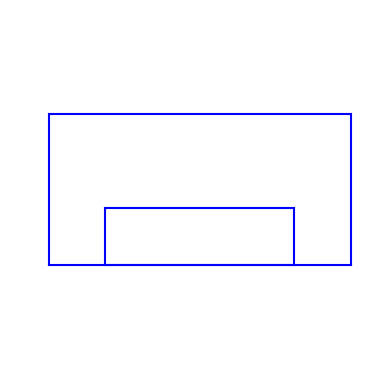

In [34]:
def get_court_frontwall_markings():
    outer_lines = np.array(
        [
            # Outer lines
            corners_world_3d["a_front_left"],
            corners_world_3d["b_front_right"],
            corners_world_3d["n_top_front_right"],
            corners_world_3d["m_top_front_left"],
            corners_world_3d["a_front_left"],
        ],
        dtype=np.float32,
    )
    x_offset = 3 * 100.0
    z_offset = 5 * 100.0
    play_boundary = np.array(
        [
            # Outer lines
            (
                corners_world_3d["a_front_left"][0] - x_offset,
                corners_world_3d["a_front_left"][1],
                corners_world_3d["a_front_left"][2],
            ),
            (
                corners_world_3d["b_front_right"][0] + x_offset,
                corners_world_3d["b_front_right"][1],
                corners_world_3d["b_front_right"][2],
            ),
            (
                corners_world_3d["n_top_front_right"][0] + x_offset,
                corners_world_3d["n_top_front_right"][1],
                corners_world_3d["n_top_front_right"][2] + z_offset,
            ),
            (
                corners_world_3d["m_top_front_left"][0] - x_offset,
                corners_world_3d["m_top_front_left"][1],
                corners_world_3d["m_top_front_left"][2] + z_offset,
            ),
            (
                corners_world_3d["a_front_left"][0] - x_offset,
                corners_world_3d["a_front_left"][1],
                corners_world_3d["a_front_left"][2],
            ),
        ],
        dtype=np.float32,
    )
    xs = np.array([outer_lines[:-1, 0], outer_lines[1:, 0]]).T
    xs = np.append(
        xs, np.array([play_boundary[:-1, 0], play_boundary[1:, 0]]).T, axis=0
    )

    ys = np.array([outer_lines[:-1, 1], outer_lines[1:, 1]]).T
    ys = np.append(
        ys, np.array([play_boundary[:-1, 1], play_boundary[1:, 1]]).T, axis=0
    )

    zs = np.array([outer_lines[:-1, 2], outer_lines[1:, 2]]).T
    zs = np.append(
        zs, np.array([play_boundary[:-1, 2], play_boundary[1:, 2]]).T, axis=0
    )

    return xs, ys, zs


xs, ys, zs = get_court_frontwall_markings()
plt_axis, fig = plot_3d_lines(xs=xs, ys=ys, zs=zs, view_init=(0, 90, 0))
plt_axis.set_title("")
plt_axis.set_xlabel("")
plt_axis.set_ylabel("")
plt_axis.set_xticks([])
plt_axis.set_yticks([])
plt_axis.set_zticks([])
plt_axis.spines["right"].set_visible(False)
plt_axis.spines["top"].set_visible(False)
plt_axis.spines["bottom"].set_visible(False)
plt_axis.spines["left"].set_visible(False)
plt.axis("off")
plt.axis("image")
plt.savefig("frontwall.png", bbox_inches=0)

In [8]:
corners_world_3d

{'a_front_left': (0.0, 0.0, 0.0),
 'b_front_right': (1000.0, 0, 0.0),
 'c_back_left': (0.0, 2000.0, 0.0),
 'd_back_right': (1000.0, 2000.0, 0.0),
 'e_left_near_serve_line': (0.0, 200.0, 0.0),
 'f_right_near_serve_line': (1000.0, 200.0, 0.0),
 'g_left_far_serve_line': (0.0, 1800.0, 0.0),
 'h_right_far_serve_line': (1000.0, 1800.0, 0.0),
 'i_center_line_far': (500, 2000, 0.0),
 'j_net_line_left': (0, 1000, 0.0),
 'k_center_line_near': (500, 0, 0.0),
 'l_net_line_right': (1000, 1000, 0.0),
 'm_top_front_left': (0.0, 0.0, 300.0),
 'n_top_front_right': (1000.0, 0, 300.0)}

NameError: name 'base_results' is not defined

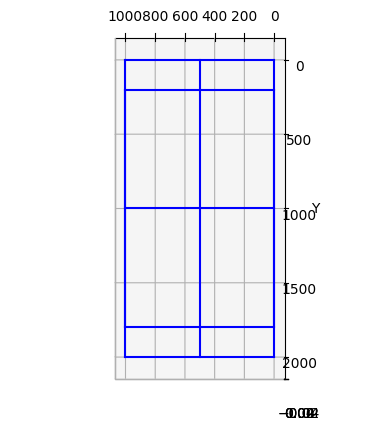

In [2]:
def get_court_markings():
    outer_lines = np.array(
        [
            # Outer lines
            corners_world_3d["a_front_left"],
            corners_world_3d["b_front_right"],
            corners_world_3d["d_back_right"],
            corners_world_3d["c_back_left"],
            corners_world_3d["a_front_left"],
        ],
        dtype=np.float32,
    )
    inner_lines = np.array(
        [
            corners_world_3d["e_left_near_serve_line"],
            corners_world_3d["f_right_near_serve_line"],
            corners_world_3d["h_right_far_serve_line"],
            corners_world_3d["g_left_far_serve_line"],
            corners_world_3d["e_left_near_serve_line"],
        ],
        dtype=np.float32,
    )

    center_line = np.array(
        [
            corners_world_3d["k_center_line_near"],
            corners_world_3d["i_center_line_far"],
        ]
    )
    net_line = np.array(
        [
            corners_world_3d["j_net_line_left"],
            corners_world_3d["l_net_line_right"],
        ]
    )

    xs = np.array([outer_lines[:-1, 0], outer_lines[1:, 0]]).T
    xs = np.append(xs, np.array([inner_lines[:-1, 0], inner_lines[1:, 0]]).T, axis=0)
    xs = np.append(xs, np.array([center_line[:-1, 0], center_line[1:, 0]]).T, axis=0)
    xs = np.append(xs, np.array([net_line[:-1, 0], net_line[1:, 0]]).T, axis=0)

    ys = np.array([outer_lines[:-1, 1], outer_lines[1:, 1]]).T
    ys = np.append(ys, np.array([inner_lines[:-1, 1], inner_lines[1:, 1]]).T, axis=0)
    ys = np.append(ys, np.array([center_line[:-1, 1], center_line[1:, 1]]).T, axis=0)
    ys = np.append(ys, np.array([net_line[:-1, 1], net_line[1:, 1]]).T, axis=0)

    zs = np.array([outer_lines[:-1, 2], outer_lines[1:, 2]]).T
    zs = np.append(zs, np.array([inner_lines[:-1, 2], inner_lines[1:, 2]]).T, axis=0)
    zs = np.append(zs, np.array([center_line[:-1, 2], center_line[1:, 2]]).T, axis=0)
    zs = np.append(zs, np.array([net_line[:-1, 2], net_line[1:, 2]]).T, axis=0)

    return xs, ys, zs


xs, ys, zs = get_court_markings()
plt_axis, fig = plot_3d_lines(xs=xs, ys=ys, zs=zs, view_init=(90, 90, 0))
from courtvision.vis import plot_3d_points

idx = 1
xs = np.array(base_results[f"{idx}_xs"])
ys = np.array(base_results[f"{idx}_ys"])
zs = np.array(base_results[f"{idx}_zs"])
plt_axis.set_title("")
plt_axis.set_xlabel("")
plt_axis.set_ylabel("")
plt_axis.set_xticks([])
plt_axis.set_yticks([])
plt_axis.set_zticks([])
plt_axis.spines["right"].set_visible(False)
plt_axis.spines["top"].set_visible(False)
plt_axis.spines["bottom"].set_visible(False)
plt_axis.spines["left"].set_visible(False)
plt.axis("off")
plt.axis("image")
plt.savefig("test.png", bbox_inches=0)

# plt_axis, _=plot_3d_points(x=xs, y=ys, z=zs, plt_axis=plt_axis ,view_init=(90, 90,0))

/var/folders/nv/c7kqzw0j08q0bg0fjbmbbr4w0000gn/T/ipykernel_42895/857977412.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [5]:
rr.log("test", "test")

TypeError: 'module' object is not callable

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

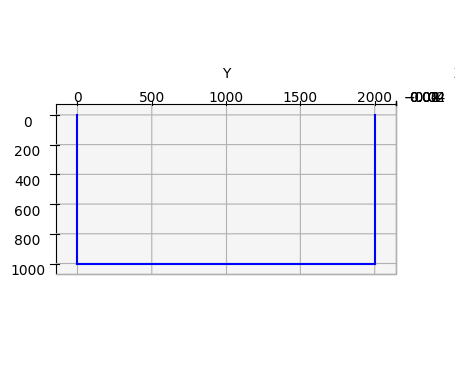

In [78]:
from courtvision.vis import plot_3d_points, plot_3d_lines
from courtvision.geometry import get_coords_world_3d
import numpy as np

court_markings = get_coords_world_3d()
xs = np.array([court_markings[:1, 0], court_markings[1:2, 0]]).T
xs = np.append(xs, np.array([court_markings[1:2, 0], court_markings[3:4, 0]]).T, axis=0)
xs = np.append(xs, np.array([court_markings[3:4, 0], court_markings[4:5, 0]]).T, axis=0)
xs = np.append(xs, np.array([court_markings[4:5, 0], court_markings[:1, 0]]).T, axis=0)

ys = np.array([court_markings[:-1, 1], court_markings[1:, 1]]).T
zs = np.array([court_markings[:-1, 2], court_markings[1:, 2]]).T
plot_3d_lines(xs=xs, ys=ys, zs=zs)
# get_coords_world_3d()